<a href="https://colab.research.google.com/github/Sara-DaCanal/Progetto-ML/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di Machine Learning

* Adrian Petru Baba
* Sara Da Canal

### Introduzione

Questo Notebook propone l'analisi di modelli di Machine Learning usati per eseguire una classificazione binaria su un dataset di funghi, per stabilire se sono edibili o velenosi. Inizialmente abbiamo effettuato una fase di preprocessing dei dati, per andare ad ottenere un dataset di qualità, poi siamo andati a testare differenti modelli di machine learning effettuando tuning dei parametri per stabilire quale modello è il migliore per il task considerato.

In [137]:
import pandas as pd
from typing import Tuple
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt


In [117]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
path_to_dataset = '/content/drive/MyDrive/secondary_data_shuffled.csv'

In [119]:
df = pd.read_csv(path_to_dataset, sep=';')
print(df.columns)
print(df.shape)

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')
(61069, 21)


Abbiamo letto il dataset importandolo come un Dataframe pandas.
Come si può vedere qui sopra, il dataset comprende 21 colonne, di cui 20 sono feature è la prima è il valore target, e 61.069 righe. Di queste colonne, tre hanno valori numerici, mentre tutte le altre presentano valori categorici. Sotto è possibile vedere quali feature appartengono a ciascuna categoria.

In [124]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
print(numerical_cols)
print("Il numero di feature numeriche è:", len(numerical_cols))
categorical_cols = df.select_dtypes(include='object').columns.to_list()
print(categorical_cols)
print("Il numero di feature categoriche è:", len(categorical_cols))

['cap-diameter', 'stem-height', 'stem-width']
Il numero di feature numeriche è: 3
['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']
Il numero di feature categoriche è: 18


# Preprocessing del dataset
Per andare ad ottenere un dataset coerente siamo andati a verificare la presenza di valori nulli nelle colonne, usando la seguente funzione:

In [125]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names

nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface          14120
gill-attachment       9884
gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
ring-type             2471
spore-print-color    54715
dtype: int64


Come si può vedere dall'output, abbiamo valori nulli in 9 colonne su 20.

In questa fase abbiamo eliminato dal dataset le colonne relative a feature in cui c'è una percentuale di valori nulli maggiore rispetto a una specifica soglia (nello specifico **75%**).
Possiamo vedere il numero minimo di valori non nulli richiesto per non cancellare la colonna.
Dal numero iniziale, con questa pulizia rimangono solo **14** feature.

In [126]:
righe = df.shape[0]
p = 0.75
def remove_nan_columns(dataset: pd.DataFrame, threshold) -> pd.DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold)) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset

new_data = remove_nan_columns(df, p)
print(new_data.shape)
print(new_data.columns)


Numero di valori non nulli minimo:  45802
(61069, 15)
Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-height',
       'stem-width', 'stem-color', 'has-ring', 'ring-type', 'habitat',
       'season'],
      dtype='object')


In [127]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()

categorical_cols = df.select_dtypes(include='object').columns.to_list()

Di seguito possiamo vedere quali, fra le rimanenti feature, hanno qualche valore nullo (ma non a sufficienza per essere cancellate in base al threshold scelto).
Di fatto, tra le colonne riguardanti feature con valori numerici, non abbiamo alcun valore null; al contrario, per le feature con valori categorici, abbiamo diversi null.
Nel primo caso, qualora ce ne fosse stato bisogno, i valori mancanti sarebbero potuti essere riempiti per esempio dalla media del valore di quella feature o con qualche strategia simile.
Nel secondo caso, abbiamo scelto di riempire gli spazi vuoti con la moda del valore della feature corrispondente.

In [128]:
nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface        14120
gill-attachment     9884
ring-type           2471
dtype: int64


Il grafico seguente mostra, nelle colonne dove abbiamo dei NaN, la media tra

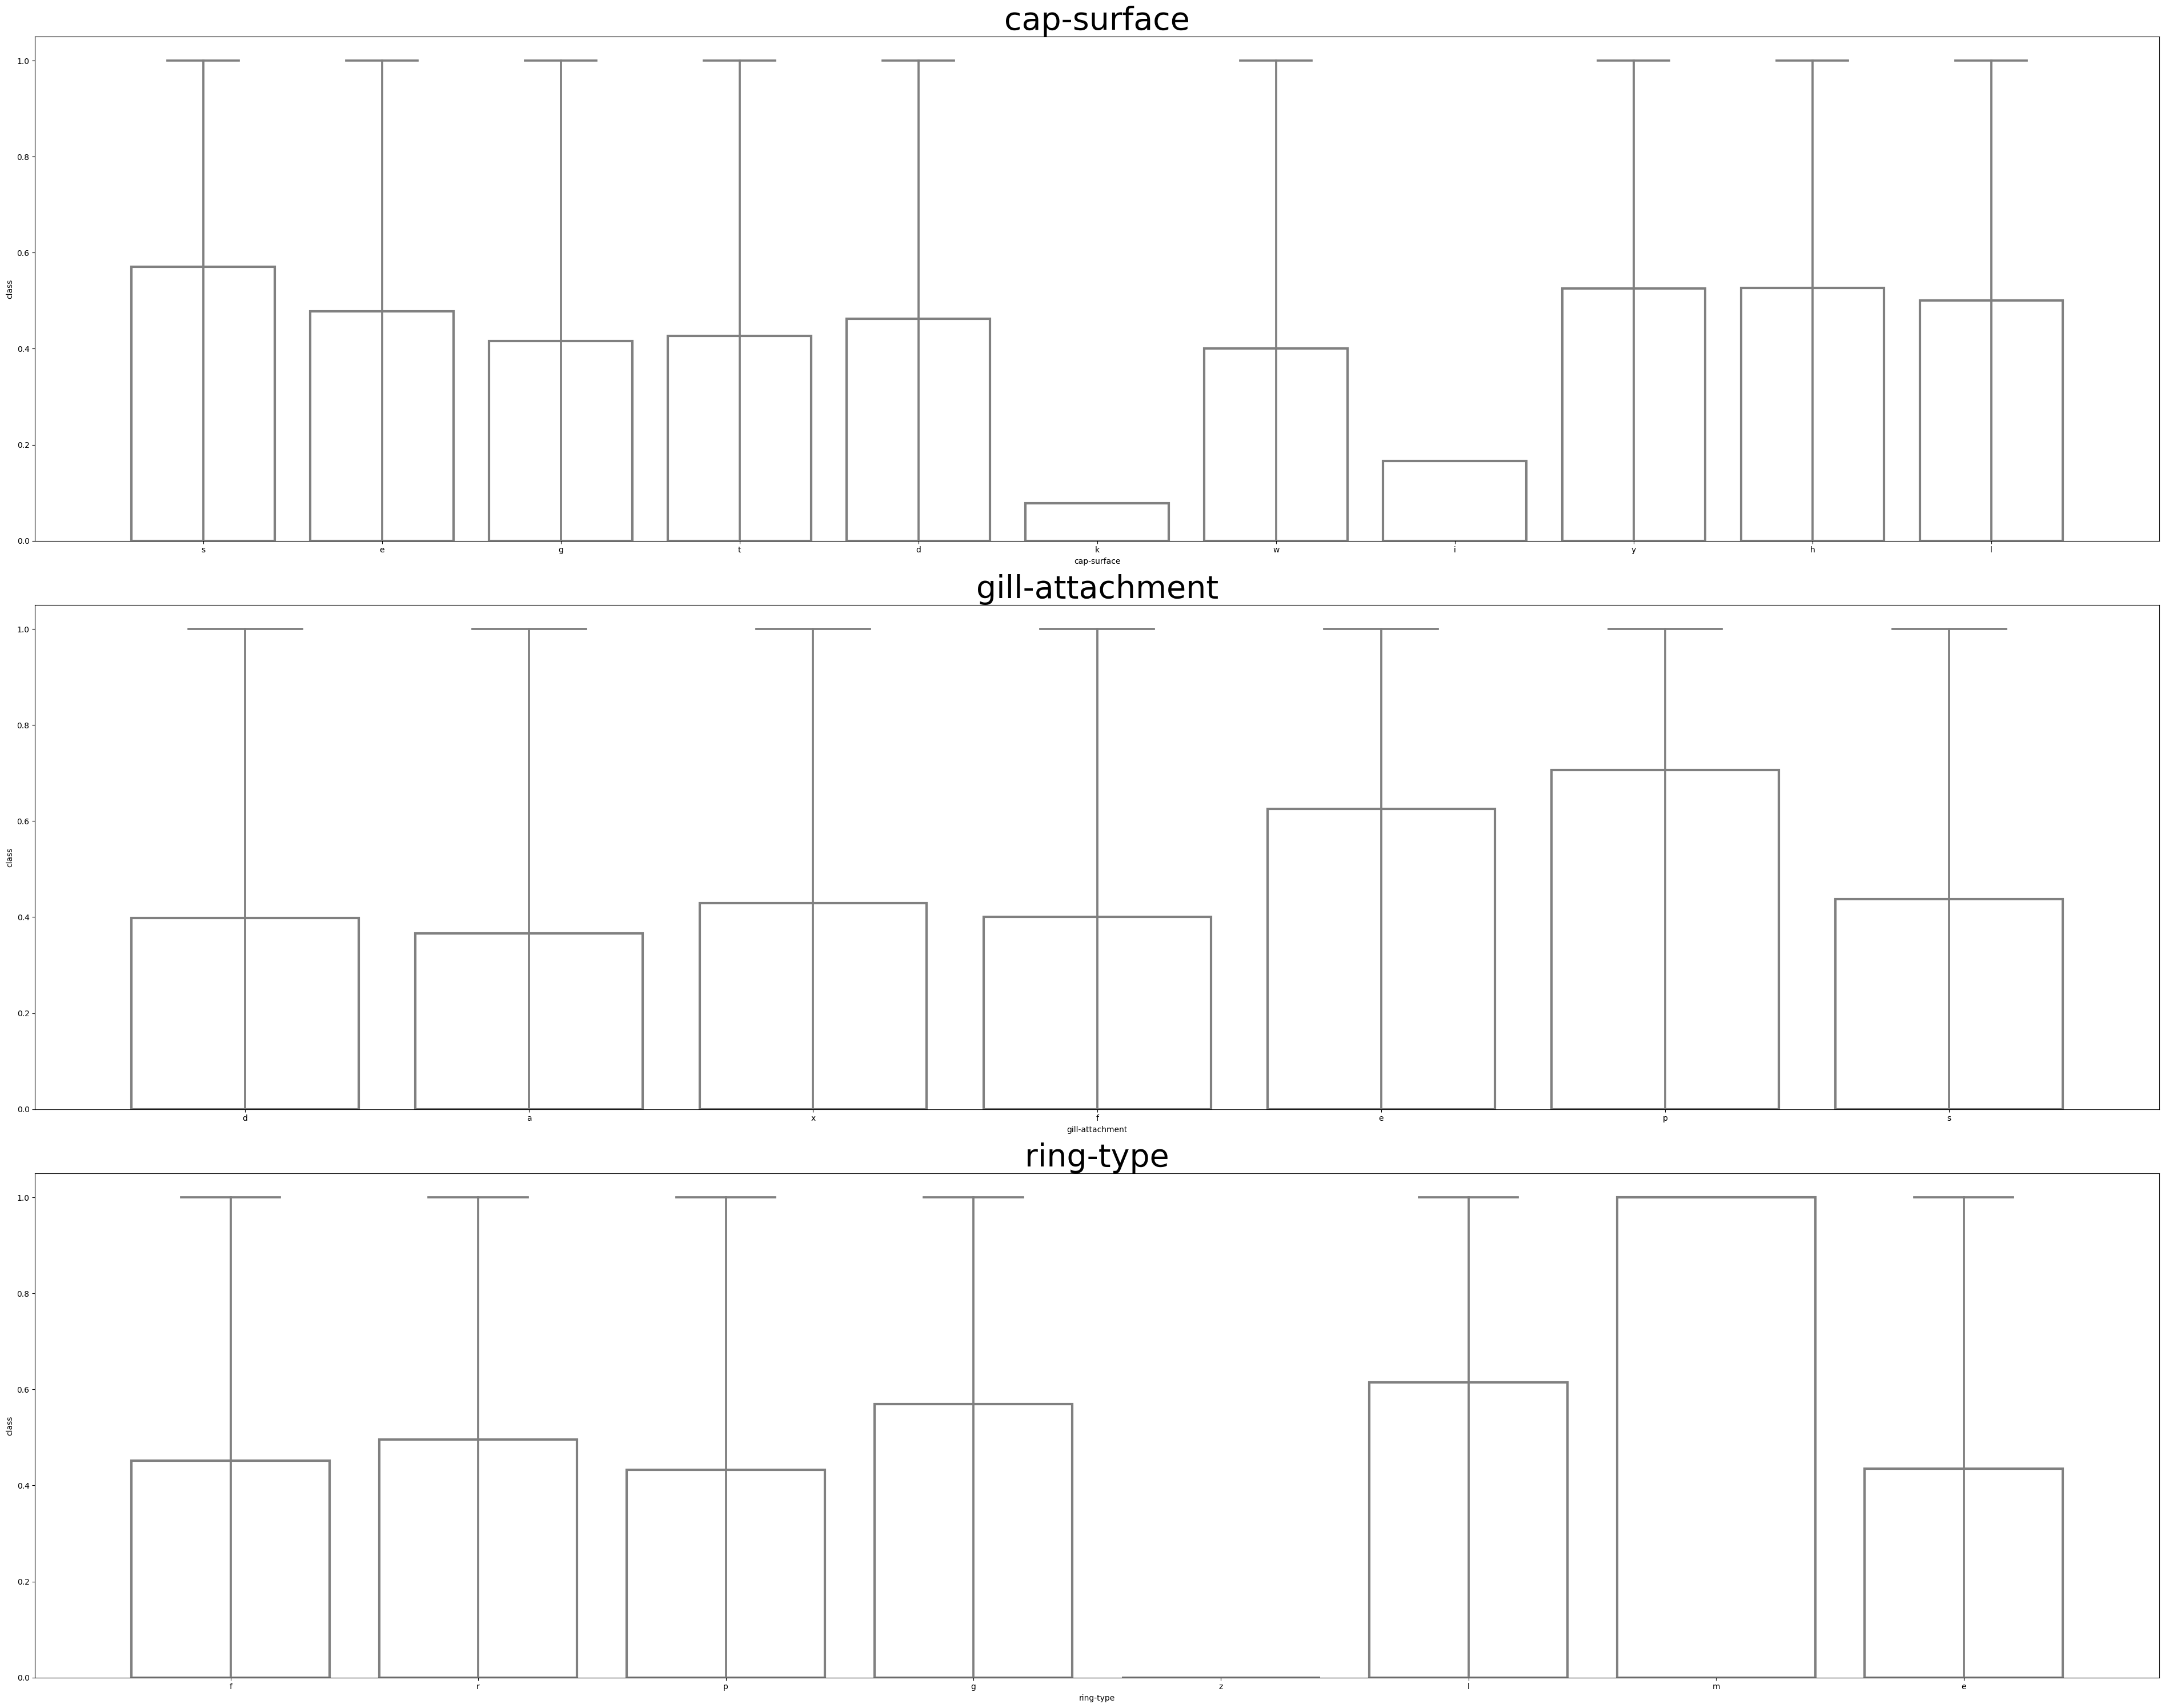

In [179]:

target = 'class'
df[target].replace(to_replace = 'e', value=1, inplace=True)
df[target].replace(to_replace = 'p', value=0, inplace=True)

fig, axes = plt.subplots(3, 1, figsize=(38, 30))
axis_x = 0
for col in nan_list:
  f = sns.barplot(data=df, x=col, y=target,
    errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),ax=axes[axis_x])
  f.axis(ymin=0, ymax=800000)
  f.set_title(col, fontsize=40)
  axes[axis_x].tick_params(rotation=0)
  axes[axis_x].autoscale(enable=True)
  fig.tight_layout()
  axis_x +=1


In [168]:
for elem in categorical_cols:
  if elem in nan_list:
    col = df[elem]
    mode = col.mode()
    print(mode.iloc[0])
    df1 = col.fillna(mode.iloc[0], inplace=True)
    print(get_nan_cols(df))


t
(gill-attachment    9884
ring-type          2471
dtype: int64, Index(['gill-attachment', 'ring-type'], dtype='object'))
a
(ring-type    2471
dtype: int64, Index(['ring-type'], dtype='object'))
f
(Series([], dtype: int64), Index([], dtype='object'))


In [170]:
df_encoded = pd.get_dummies(df, columns=categorical_cols[1:])
print(df_encoded)

       class  cap-diameter  stem-height  stem-width  cap-shape_b  cap-shape_c  \
0          1          1.72         7.01        2.36            0            0   
1          1          9.59         4.73       20.49            0            0   
2          0          0.86         4.25        1.05            0            0   
3          0          4.32         4.91        6.58            0            0   
4          1          2.80         3.13        5.69            0            0   
...      ...           ...          ...         ...          ...          ...   
61064      0         13.81        10.06       31.63            0            0   
61065      0          2.69         3.76        2.41            0            0   
61066      1         11.70         7.36       20.73            0            0   
61067      0          2.83         5.76        5.59            0            0   
61068      0          1.57         3.26        2.27            0            0   

       cap-shape_f  cap-sha